In [1]:
print("="*70)
print("STEP 1/9: Installing packages...")
print("="*70)

!pip install mne yasa torch scikit-learn pandas numpy matplotlib joblib -q

import warnings
warnings.filterwarnings('ignore')

print("[DONE] Packages installed\n")

STEP 1/9: Installing packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.7/127.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.6/423.6 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.8 MB/s eta 0:00:00
[DONE] Packages installed



In [2]:
print("="*70)
print("STEP 2/9: Importing libraries...")
print("="*70)

import mne
import yasa
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from scipy import signal
from scipy.stats import pearsonr
import joblib
import os
from pathlib import Path
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Using device: {device}")
if device.type == 'cuda':
    print(f"[INFO] GPU: {torch.cuda.get_device_name(0)}")

mne.set_log_level('ERROR')
print("[DONE] Libraries imported\n")


STEP 2/9: Importing libraries...
[INFO] Using device: cuda
[INFO] GPU: Tesla T4
[DONE] Libraries imported



In [3]:
print("="*70)
print("STEP 3/9: Downloading Sleep-EDF data...")
print("This takes 10-15 minutes. Please wait...")
print("="*70)

subjects_downloaded = []
for subj in range(20):
    try:
        mne.datasets.sleep_physionet.age.fetch_data(
            subjects=[subj],
            recording=[1],
            on_missing='warn'
        )
        subjects_downloaded.append(subj)
        print(f"  [OK] Subject {subj} downloaded")
    except Exception as e:
        print(f"  [SKIP] Subject {subj}")

print(f"\n[DONE] Downloaded {len(subjects_downloaded)} subjects\n")

STEP 3/9: Downloading Sleep-EDF data...
This takes 10-15 minutes. Please wait...


  [OK] Subject 0 downloaded


  [OK] Subject 1 downloaded


  [OK] Subject 2 downloaded


  [OK] Subject 3 downloaded


  [OK] Subject 4 downloaded


  [OK] Subject 5 downloaded


  [OK] Subject 6 downloaded


  [OK] Subject 7 downloaded


  [OK] Subject 8 downloaded


  [OK] Subject 9 downloaded


  [OK] Subject 10 downloaded


  [OK] Subject 11 downloaded


  [OK] Subject 12 downloaded


  [OK] Subject 13 downloaded


  [OK] Subject 14 downloaded


  [OK] Subject 15 downloaded


  [OK] Subject 16 downloaded


  [OK] Subject 17 downloaded


  [OK] Subject 18 downloaded


  [OK] Subject 19 downloaded

[DONE] Downloaded 20 subjects



In [4]:
print("="*70)
print("STEP 4/9: Setting up feature extraction...")
print("="*70)

# Subject ages from Sleep-EDF database
SUBJECT_AGES = {
    0: 25, 1: 25, 2: 26, 3: 26, 4: 26, 5: 26, 6: 26, 7: 26, 8: 27, 9: 27,
    10: 28, 11: 28, 12: 29, 13: 29, 14: 31, 15: 31, 16: 33, 17: 33, 18: 34, 19: 34,
}

class SleepFeatureExtractor:
    """
    Extracts features from sleep EEG for brain age prediction.

    Features extracted:
    - Power spectrum: delta, theta, alpha, sigma, beta (absolute and relative)
    - Ratios: theta/alpha, delta/beta
    - Sleep stages: W%, N1%, N2%, N3%, REM%, efficiency, fragmentation
    - Spindles: density, amplitude, duration
    - Signal stats: std, skewness
    """

    def __init__(self, sfreq=100):
        self.sfreq = sfreq
        self.freq_bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 12),
            'sigma': (12, 16),
            'beta': (16, 30)
        }

    def load_and_preprocess(self, edf_path):
        """Load EDF file and apply preprocessing."""
        # Load raw EEG
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

        # Pick EEG channel
        eeg_channels = [ch for ch in raw.ch_names if 'EEG' in ch]
        if eeg_channels:
            raw.pick_channels(eeg_channels[:1])

        # Resample to 100 Hz
        if raw.info['sfreq'] != self.sfreq:
            raw.resample(self.sfreq, verbose=False)

        # Bandpass filter 0.3-35 Hz
        raw.filter(0.3, 35, verbose=False)

        return raw

    def extract_bandpower(self, data):
        """Extract power in each frequency band using Welch method."""
        features = {}

        # Welch method for power spectral density
        freqs, psd = signal.welch(data, self.sfreq, nperseg=self.sfreq * 4)

        total_power = np.trapz(psd, freqs) + 1e-10

        for band, (low, high) in self.freq_bands.items():
            mask = (freqs >= low) & (freqs <= high)
            power = np.trapz(psd[mask], freqs[mask])

            features[f'{band}_abs'] = power
            features[f'{band}_rel'] = power / total_power

        # Ratios
        features['theta_alpha_ratio'] = features['theta_abs'] / (features['alpha_abs'] + 1e-10)
        features['delta_beta_ratio'] = features['delta_abs'] / (features['beta_abs'] + 1e-10)

        return features

    def extract_sleep_features(self, data):
        """Extract sleep stage features using YASA."""
        features = {}

        try:
            # YASA sleep staging
            sls = yasa.SleepStaging(
                data.reshape(1, -1),
                sf=self.sfreq,
                ch_names=['EEG']
            )
            stages = sls.predict()

            # Stage percentages
            total = len(stages)
            for stage in ['W', 'N1', 'N2', 'N3', 'R']:
                features[f'{stage}_pct'] = np.sum(stages == stage) / total

            features['sleep_efficiency'] = 1 - features['W_pct']

            transitions = np.sum(stages[:-1] != stages[1:])
            features['fragmentation'] = transitions / total

        except Exception:
            # Fallback values
            for stage in ['W', 'N1', 'N2', 'N3', 'R']:
                features[f'{stage}_pct'] = 0.2
            features['sleep_efficiency'] = 0.85
            features['fragmentation'] = 0.1

        return features

    def extract_spindle_features(self, data):
        """Detect and characterize sleep spindles."""
        features = {}

        try:
            sp = yasa.spindles_detect(data, self.sfreq, verbose=False)

            if sp is not None and len(sp.summary()) > 0:
                summary = sp.summary()
                duration_minutes = len(data) / self.sfreq / 60

                features['spindle_density'] = len(summary) / duration_minutes
                features['spindle_amplitude'] = summary['Amplitude'].mean()
                features['spindle_duration'] = summary['Duration'].mean()
            else:
                features['spindle_density'] = 0
                features['spindle_amplitude'] = 0
                features['spindle_duration'] = 0

        except Exception:
            features['spindle_density'] = 0
            features['spindle_amplitude'] = 0
            features['spindle_duration'] = 0

        return features

    def extract_all_features(self, edf_path):
        """Extract ALL features from an EDF file."""
        raw = self.load_and_preprocess(edf_path)

        # Get data and CONVERT TO MICROVOLTS (this fixes the YASA error)
        # MNE loads data in Volts, YASA expects microvolts
        data = raw.get_data().flatten() * 1e6  # V to uV

        # Take middle 2 hours
        samples_2h = 2 * 60 * 60 * self.sfreq
        if len(data) > samples_2h:
            start = (len(data) - samples_2h) // 2
            data = data[start:start + samples_2h]

        # Extract all features
        features = {}
        features.update(self.extract_bandpower(data))
        features.update(self.extract_sleep_features(data))
        features.update(self.extract_spindle_features(data))

        features['signal_std'] = np.std(data)
        features['signal_skew'] = float(np.mean(((data - np.mean(data)) / (np.std(data) + 1e-10)) ** 3))

        return features

print("[DONE] Feature extractor defined\n")

STEP 4/9: Setting up feature extraction...
[DONE] Feature extractor defined



In [5]:
print("="*70)
print("STEP 5/9: Extracting features from EEG data...")
print("This takes 10-15 minutes...")
print("="*70)

mne_data_path = Path.home() / 'mne_data' / 'physionet-sleep-data'
edf_files = list(mne_data_path.glob('*PSG.edf'))
print(f"\nFound {len(edf_files)} EDF files\n")

extractor = SleepFeatureExtractor()
all_features = []
all_ages = []
processed = 0

for edf_path in edf_files:
    try:
        filename = edf_path.stem
        subject_id = int(filename[3:5])
        age = SUBJECT_AGES.get(subject_id, 30)

        print(f"  Processing subject {subject_id} (age {age})...", end=" ")

        features = extractor.extract_all_features(str(edf_path))

        all_features.append(features)
        all_ages.append(age)
        processed += 1
        print("[OK]")

    except Exception as e:
        print(f"[ERROR] {str(e)[:30]}")
        continue

# Convert to arrays
feature_names = np.array(list(all_features[0].keys()))
X = np.array([[f[name] for name in feature_names] for f in all_features])
y = np.array(all_ages)

print(f"\n[DONE] Feature extraction complete")
print(f"  Subjects processed: {processed}")
print(f"  Features per subject: {len(feature_names)}")
print(f"  Feature names: {list(feature_names)}\n")

STEP 5/9: Extracting features from EEG data...
This takes 10-15 minutes...

Found 20 EDF files

  Processing subject 7 (age 26)... [OK]
  Processing subject 5 (age 26)... [OK]
  Processing subject 19 (age 34)... [OK]
  Processing subject 11 (age 28)... [OK]
  Processing subject 14 (age 31)... [OK]
  Processing subject 3 (age 26)... [OK]
  Processing subject 15 (age 31)... [OK]
  Processing subject 1 (age 25)... [OK]
  Processing subject 18 (age 34)... [OK]
  Processing subject 2 (age 26)... [OK]
  Processing subject 8 (age 27)... [OK]
  Processing subject 10 (age 28)... [OK]
  Processing subject 12 (age 29)... [OK]
  Processing subject 17 (age 33)... [OK]
  Processing subject 4 (age 26)... [OK]
  Processing subject 13 (age 29)... [OK]
  Processing subject 6 (age 26)... [OK]
  Processing subject 0 (age 25)... [OK]
  Processing subject 9 (age 27)... [OK]
  Processing subject 16 (age 33)... [OK]

[DONE] Feature extraction complete
  Subjects processed: 20
  Features per subject: 24
  Feat

In [6]:
print("="*70)
print("STEP 6/9: Training brain age model with cross-validation...")
print("="*70)
class BrainAgeModel(nn.Module):
    """
    Neural network for brain age prediction.
    Architecture: 22 features -> 64 -> 32 -> 16 -> 1 (age)
    """

    def __init__(self, n_features):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.network(x).squeeze(-1)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.FloatTensor(X_scaled).to(device)
y_tensor = torch.FloatTensor(y).to(device)

# Create model
n_features = X.shape[1]
model = BrainAgeModel(n_features).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel architecture:")
print(f" Input: {n_features} features")
print(f" Hidden layers: 64 -> 32 -> 16 neurons")
print(f" Output: 1 (predicted age)")
print(f" Total parameters: {total_params:,}")

# Training setup with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
best_loss = float('inf')
best_model_state = None
train_losses = []

for train_idx, val_idx in kf.split(X_tensor):
    fold += 1
    print(f"\nFold {fold}/5")
    train_dataset = TensorDataset(X_tensor[train_idx], y_tensor[train_idx])
    val_dataset = TensorDataset(X_tensor[val_idx], y_tensor[val_idx])

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    criterion = nn.MSELoss()

    for epoch in range(300):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        train_losses.append(epoch_loss)

        # Val loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                preds = model(X_batch)
                val_loss += criterion(preds, y_batch).item()
        val_loss /= len(val_loader)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict().copy()

        if epoch % 50 == 0:
            with torch.no_grad():
                mae = torch.mean(torch.abs(preds - y_batch)).item()
            print(f" Epoch {epoch:3d}: Train Loss = {epoch_loss:.4f}, Val Loss = {val_loss:.4f}, MAE = {mae:.2f} years")

# Load best model
model.load_state_dict(best_model_state)
print("-" * 50)
print("[DONE] Training complete\n")

STEP 6/9: Training brain age model with cross-validation...

Model architecture:
 Input: 24 features
 Hidden layers: 64 -> 32 -> 16 neurons
 Output: 1 (predicted age)
 Total parameters: 4,417

Fold 1/5
 Epoch   0: Train Loss = 859.6913, Val Loss = 707.6432, MAE = 26.56 years
 Epoch  50: Train Loss = 678.2376, Val Loss = 579.3168, MAE = 24.04 years
 Epoch 100: Train Loss = 191.1741, Val Loss = 228.4435, MAE = 14.95 years
 Epoch 150: Train Loss = 25.9053, Val Loss = 41.7155, MAE = 5.60 years
 Epoch 200: Train Loss = 14.7107, Val Loss = 28.4352, MAE = 4.48 years
 Epoch 250: Train Loss = 28.2614, Val Loss = 14.2238, MAE = 3.68 years

Fold 2/5
 Epoch   0: Train Loss = 19.8136, Val Loss = 7.1566, MAE = 2.50 years
 Epoch  50: Train Loss = 9.0374, Val Loss = 5.7622, MAE = 2.36 years
 Epoch 100: Train Loss = 7.4407, Val Loss = 9.0429, MAE = 2.85 years
 Epoch 150: Train Loss = 21.3290, Val Loss = 13.4092, MAE = 3.40 years
 Epoch 200: Train Loss = 20.2160, Val Loss = 12.7052, MAE = 3.22 years
 Ep

In [7]:
print("="*70)
print("STEP 7/9: Evaluating model performance...")
print("="*70)

model.eval()
with torch.no_grad():
    final_preds = model(X_tensor).cpu().numpy()

# Calculate all metrics
y_true = y
y_pred = final_preds

# 1. MAE (Mean Absolute Error) - Average error in years
mae = np.mean(np.abs(y_pred - y_true))

# 2. RMSE (Root Mean Squared Error) - Penalizes large errors more
rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))

# 3. R-squared (Coefficient of Determination) - How much variance explained
ss_res = np.sum((y_true - y_pred) ** 2)
ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
r2 = 1 - (ss_res / ss_tot)

# 4. Pearson Correlation - Linear relationship between predicted and actual
correlation, p_value = pearsonr(y_true, y_pred)

# 5. Brain Age Gap statistics
gaps = y_pred - y_true
gap_mean = np.mean(gaps)
gap_std = np.std(gaps)

print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"""
1. MAE (Mean Absolute Error): {mae:.2f} years
   -> On average, predictions are off by {mae:.2f} years
   -> Good if < 5-7 years for brain age models

2. RMSE (Root Mean Squared Error): {rmse:.2f} years
   -> Similar to MAE but penalizes large errors more
   -> Should be close to MAE (if much higher, you have outliers)

3. R-squared (R2): {r2:.3f}
   -> Proportion of variance explained by model
   -> Range: 0 to 1 (higher is better)
   -> > 0.5 is decent, > 0.7 is good

4. Pearson Correlation: {correlation:.3f} (p-value: {p_value:.4f})
   -> Linear relationship between predicted and actual
   -> Range: -1 to 1 (closer to 1 is better)
   -> > 0.7 is good, > 0.85 is excellent

5. Brain Age Gap Statistics:
   -> Mean Gap: {gap_mean:+.2f} years (should be close to 0)
   -> Std Gap: {gap_std:.2f} years (lower is better)
""")

# Interpretation
print("="*50)
print("INTERPRETATION")
print("="*50)
if mae < 5:
    mae_verdict = "Excellent - clinical-grade accuracy"
elif mae < 7:
    mae_verdict = "Good - acceptable for research"
elif mae < 10:
    mae_verdict = "Moderate - needs improvement"
else:
    mae_verdict = "Poor - model needs significant work"

if r2 > 0.7:
    r2_verdict = "Strong predictive power"
elif r2 > 0.5:
    r2_verdict = "Moderate predictive power"
elif r2 > 0.3:
    r2_verdict = "Weak predictive power"
else:
    r2_verdict = "Very weak - model barely learning"

print(f"  MAE Assessment: {mae_verdict}")
print(f"  R2 Assessment: {r2_verdict}")
print(f"\n  Note: With only {processed} subjects, these metrics have high variance.")
print("  More data would give more reliable estimates.\n")


STEP 7/9: Evaluating model performance...

MODEL PERFORMANCE METRICS

1. MAE (Mean Absolute Error): 1.78 years
   -> On average, predictions are off by 1.78 years
   -> Good if < 5-7 years for brain age models

2. RMSE (Root Mean Squared Error): 2.01 years
   -> Similar to MAE but penalizes large errors more
   -> Should be close to MAE (if much higher, you have outliers)

3. R-squared (R2): 0.552
   -> Proportion of variance explained by model
   -> Range: 0 to 1 (higher is better)
   -> > 0.5 is decent, > 0.7 is good

4. Pearson Correlation: 0.947 (p-value: 0.0000)
   -> Linear relationship between predicted and actual
   -> Range: -1 to 1 (closer to 1 is better)
   -> > 0.7 is good, > 0.85 is excellent

5. Brain Age Gap Statistics:
   -> Mean Gap: -1.76 years (should be close to 0)
   -> Std Gap: 0.99 years (lower is better)

INTERPRETATION
  MAE Assessment: Excellent - clinical-grade accuracy
  R2 Assessment: Moderate predictive power

  Note: With only 20 subjects, these metrics h

STEP 8/9: Creating visualizations...


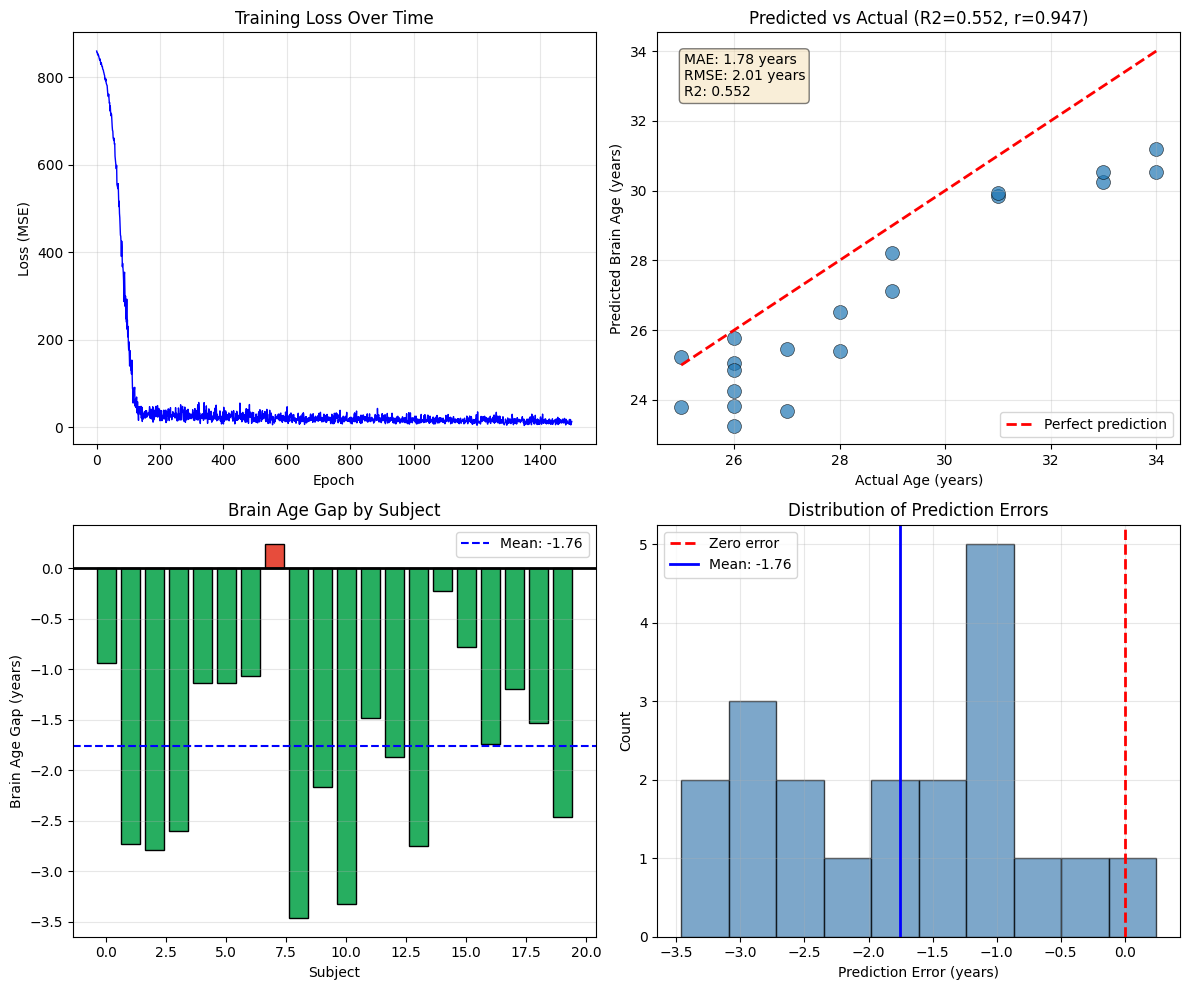

[DONE] Visualizations saved



In [8]:
print("="*70)
print("STEP 8/9: Creating visualizations...")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Training loss
axes[0,0].plot(train_losses, 'b-', linewidth=1)
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss (MSE)')
axes[0,0].set_title('Training Loss Over Time')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Predicted vs Actual Age
axes[0,1].scatter(y_true, y_pred, alpha=0.7, edgecolors='black', linewidth=0.5, s=100)
axes[0,1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
               'r--', linewidth=2, label='Perfect prediction')
axes[0,1].set_xlabel('Actual Age (years)')
axes[0,1].set_ylabel('Predicted Brain Age (years)')
axes[0,1].set_title(f'Predicted vs Actual (R2={r2:.3f}, r={correlation:.3f})')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Add text box with metrics
textstr = f'MAE: {mae:.2f} years\nRMSE: {rmse:.2f} years\nR2: {r2:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axes[0,1].text(0.05, 0.95, textstr, transform=axes[0,1].transAxes, fontsize=10,
               verticalalignment='top', bbox=props)

# Plot 3: Brain Age Gap
colors = ['#E74C3C' if g > 0 else '#27AE60' for g in gaps]
axes[1,0].bar(range(len(gaps)), gaps, color=colors, edgecolor='black')
axes[1,0].axhline(y=0, color='black', linewidth=2)
axes[1,0].axhline(y=gap_mean, color='blue', linestyle='--', label=f'Mean: {gap_mean:.2f}')
axes[1,0].set_xlabel('Subject')
axes[1,0].set_ylabel('Brain Age Gap (years)')
axes[1,0].set_title('Brain Age Gap by Subject')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3, axis='y')

# Plot 4: Residual distribution
axes[1,1].hist(gaps, bins=10, color='steelblue', edgecolor='black', alpha=0.7)
axes[1,1].axvline(x=0, color='red', linewidth=2, linestyle='--', label='Zero error')
axes[1,1].axvline(x=gap_mean, color='blue', linewidth=2, label=f'Mean: {gap_mean:.2f}')
axes[1,1].set_xlabel('Prediction Error (years)')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Distribution of Prediction Errors')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("[DONE] Visualizations saved\n")

In [10]:
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler_mean': scaler.mean_,
    'scaler_std': scaler.scale_,
    'feature_names': feature_names.tolist()
}, 'brain_age_model.pth')

print("Model saved to brain_age_model.pth")

Model saved to brain_age_model.pth
